## ARMA Modeling: Forecasting

**Functions**

`tsa.SARIMAX.forecast`

### Exercise 70
Produce 1-step forecasts from your preferred model in the previous exercise, as well
as a random-walk model. 

1. Are the forecasts objectively accurate?
2. Compare these forecasts to the random walk models using MSE and MAE.

**Note**: Use 50% of the sample to estimate the model and 50% to evaluate it.

In [1]:
import pandas as pd
data = pd.read_hdf("data/term-premium.h5", "term_premium")
term = data["TERM"]

In [2]:
import statsmodels.tsa.api as tsa

nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   TERM   No. Observations:                  406
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -73.462
Date:                Tue, 15 Dec 2020   AIC                            154.924
Time:                        17:32:55   BIC                            170.949
Sample:                    04-01-1953   HQIC                           161.266
                         - 01-01-1987                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0569      0.022      2.588      0.010       0.014       0.100
ar.L1          0.8944      0.017     53.797      0.000       0.862       0.927
ma.L1          0.4603      0.020     22.922      0.000       0.421       0.500
sigma2         0.0836      0.003     26.705      0.000       0.077       0.090
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               933.37
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               6.70   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3]:
mod = tsa.statespace.SARIMAX(term, order=(1,0,1), trend="c")
forecast_res = mod.filter(res.params)

fcast = forecast_res.predict()

errors = term - fcast
oos_errors = errors.iloc[half:]

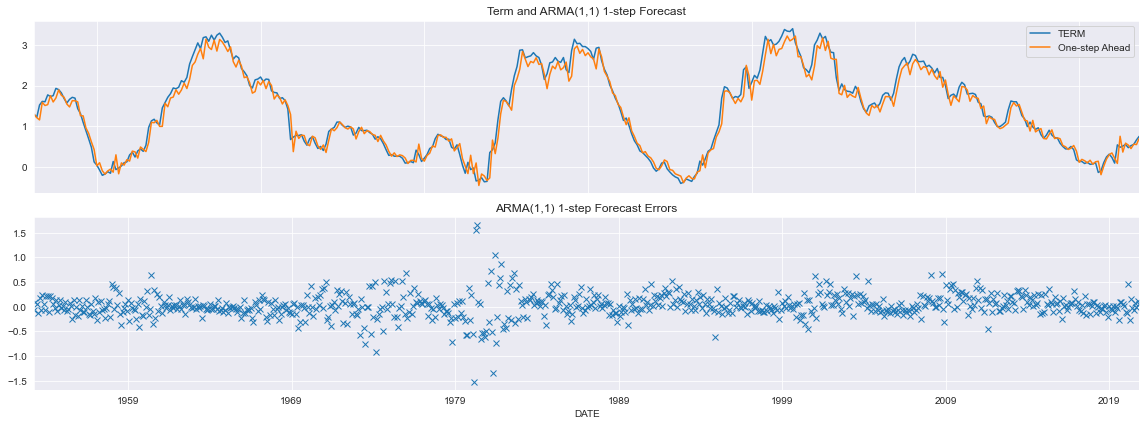

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16,6))

both = pd.concat([term, fcast],1)
both.columns = ['TERM', "One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2,1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and ARMA(1,1) 1-step Forecast")
errors = both.TERM - both["One-step Ahead"]
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("ARMA(1,1) 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

In [5]:
import statsmodels.api as sm

oos_fcast = sm.add_constant(fcast.iloc[half:])
oos_fcast.columns = ["Const", "Forecast"]
res = sm.OLS(oos_errors, oos_fcast).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     44.32
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           9.13e-11
Time:                        17:32:56   Log-Likelihood:                 148.41
No. Observations:                 406   AIC:                            -292.8
Df Residuals:                     404   BIC:                            -284.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const         -0.0158      0.014     -1.107      0.269      -0.044       0.012
Forecast       0.0575      0.009      6.657      0.000       0.041       0.075
==============================================================================
Omnibus:                       27.934   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.025
Skew:                           0.369   Prob(JB):                     9.24e-14
Kurtosis:                       4.733   Cond. No.                         3.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
import numpy as np
r_matrix = np.eye(2)
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[48.91280306]]), p=9.492192783385661e-20, df_denom=404, df_num=2>

In [7]:
rw_forecast = term.shift(1)
both = pd.concat([term, rw_forecast],1)
rw_error = term - rw_forecast
rw_oos_error = rw_error.iloc[half:]
rw_forecast = sm.add_constant(rw_forecast)
rw_forecast = rw_forecast.iloc[half:]
rw_forecast.columns = ["Const", "One-step RW Forecast"]
res = sm.OLS(rw_oos_error, rw_forecast).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TERM   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.719
Date:                Tue, 15 Dec 2020   Prob (F-statistic):             0.0999
Time:                        17:32:56   Log-Likelihood:                 132.82
No. Observations:                 406   AIC:                            -261.6
Df Residuals:                     404   BIC:                            -253.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Const                    0.0180      0.015      1.232      0.218      -0.011       0.047
One-step RW Forecast    -0.0138      0.008     -1.649      0.100      -0.030       0.003
==============================================================================
Omnibus:                       40.917   Durbin-Watson:                   1.429
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.791
Skew:                           0.486   Prob(JB):                     1.07e-23
Kurtosis:                       5.304   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.37174673]]), p=0.2548423736830769, df_denom=404, df_num=2>

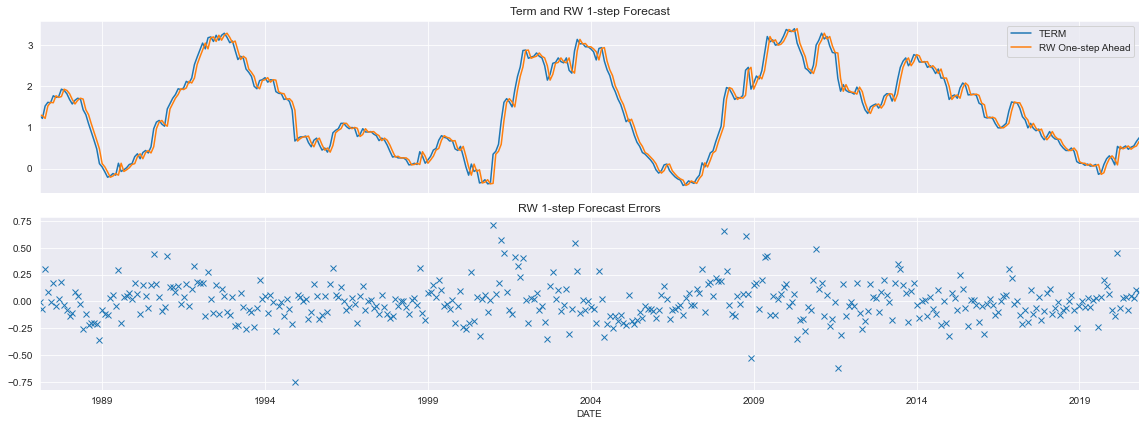

In [9]:
plt.rc("figure", figsize=(16,6))

both.columns = ['TERM', "RW One-step Ahead"]
both_oos = both.iloc[half:]
fig, axes = plt.subplots(2,1)
both_oos.plot.line(ax=axes[0])
axes[0].set_xticklabels([])
axes[0].set_xlabel("")
axes[0].set_title("Term and RW 1-step Forecast")

errors = rw_oos_error
errors.plot.line(ax=axes[1], linestyle="none", marker="x")
axes[1].set_title("RW 1-step Forecast Errors")
fig.tight_layout(pad=1.0)

### Exercise 71

Produce 3-step forecasts from the models selected in the previous exercises as well as a random walk model.

1. Compare these forecasts to the random walk models using MSE and MAE.


In [10]:
nobs = term.shape[0]
half = nobs // 2
mod = tsa.SARIMAX(term.iloc[:half], order=(1, 0, 1), trend="c")
res = mod.fit()
res.summary()

mod = tsa.statespace.SARIMAX(term, order=(1,0,1), trend="c")
forecast_res = mod.filter(res.params)

In [11]:
three_step = {}
for t in range(half, nobs):
    fcasts = forecast_res.predict(t, t+2, dynamic=True)
    key = fcasts.index[-1]
    value = fcasts.iloc[-1]
    three_step[key] = value
three_step = pd.Series(three_step)

In [12]:
three_step_errors = term - three_step
three_step_errors = three_step_errors.dropna()
three_step_errors


1987-04-01    0.377268
1987-05-01    0.534908
1987-06-01    0.569635
1987-07-01    0.393922
1987-08-01    0.415522
                ...   
2020-07-01    0.072935
2020-08-01   -0.053012
2020-09-01    0.014630
2020-10-01    0.194002
2020-11-01    0.197881
Length: 404, dtype: float64

In [13]:
three_step_rw = term.shift(3)
three_step_rw_errors = term - three_step_rw
three_step_rw_errors = three_step_rw_errors.iloc[half:]

In [14]:
errors = pd.DataFrame({"ARMA": three_step_errors, "RW": three_step_rw_errors}).dropna()
pd.DataFrame([(errors ** 2).mean(), errors.abs().mean()], index=['MSE', 'MAE'])

,ARMA,RW
MSE,0.209583,0.130221
MAE,0.350717,0.276015


In [15]:
d = errors["ARMA"] ** 2 - errors["RW"] ** 2
x = np.ones_like(d)
maxlags = int(d.shape[0] ** (1/3))
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 15 Dec 2020   Prob (F-statistic):                nan
Time:                        17:32:58   Log-Likelihood:                -18.869
No. Observations:                 404   AIC:                             39.74
Df Residuals:                     403   BIC:                             43.74
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0794      0.026      3.083      0.002       0.029       0.130
==============================================================================
Omnibus:                       88.366   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.263
Skew:                           1.085   Prob(JB):                     4.90e-47
Kurtosis:                       5.821   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""

In [16]:
d = errors["ARMA"].abs() - errors["RW"].abs()
res = sm.OLS(d, x).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 15 Dec 2020   Prob (F-statistic):                nan
Time:                        17:32:58   Log-Likelihood:                -47.736
No. Observations:                 404   AIC:                             97.47
Df Residuals:                     403   BIC:                             101.5
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.027      2.786      0.005       0.022       0.127
==============================================================================
Omnibus:                        0.488   Durbin-Watson:                   0.539
Prob(Omnibus):                  0.783   Jarque-Bera (JB):                0.556
Skew:                           0.080   Prob(JB):                        0.757
Kurtosis:                       2.916   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 7 lags and without small sample correction
"""